## DS807: Applied machine learning
Christian M. Dahl. cmd@sam.sdu.dk.

## Optimization and Regularization

Notes: For the purpose of this notebook, DLWP refers to Deep Learning with Python by Francois Collet (ISBN10: 9781617294433).

## Program

After this lecture, you will:
1. Know the trade-offs between model capability and overfitting when using small versus large models.
1. Know how to use validation data to stop training when overfitting starts.
1. Know how to use weight regularization to improve generalization.
1. Know how to use dropout to improve generalization.
1. Know how to use batch normalization to improve training and generalization.
1. Know what data augmentation is (which we will cover in more detail later).
1. Have applied the techniques in (1)-(5) to improve the performance of your models.

## Setup

We will be going through very general techniques to improve neural networks. These techniques are essential to build successful neural networks, and can - with benefit - be combined.

To see the methods in action, we will go through each method applied to the fastion MNIST data (as we saw last time). Specifically, we will use three models (small, medium, and large in size) combined with each of the methods, to see how the methods change the models and their performances.

These methods are some that we will return to throughout the semester.

First, let's introduce two useful functions for today (which you may want to study in detail at a later time).

In [1]:
import tensorflow as tf

from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

4422102/4422102 [==============================] - 1s 0us/step


In [2]:
def build_model(size, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(28, 28))]
    
    nb_layers = size
    nb_neurons = size ** 2 * 4
    
    for i in range(nb_layers):
        layers.append(tf.keras.layers.Dense(nb_neurons, activation=activation, 
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.2))

    layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    
    model = tf.keras.models.Sequential(layers)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )
    
    return model

In [3]:
def plot_histories(histories, names, measure,xlim_max=40,ylim_min=0,ylim_max=0):
    measure_to_pretty = {'sparse_categorical_crossentropy': 'loss', 
                         'accuracy': 'accuracy'}
    nb_histories = len(histories)
    fig = plt.figure(figsize=plt.figaspect(0.05 * nb_histories))
    
    for i in range(nb_histories):
        ax = fig.add_subplot(1, nb_histories, i + 1)
        ax.plot(histories[i].history[f'val_{measure}'], 
                label=f'Test {measure_to_pretty[measure]}, {names[i]}')
        plt.xlabel('Epoch')
        plt.ylabel(measure)
        plt.legend()
        plt.xlim(0,xlim_max)
        plt.ylim(ylim_min,ylim_max)
        #plt.gca().set_aspect('equal', adjustable='box')
        plt.draw()


    plt.show()

## What is happening when a model is overfitting?

Before we start, it is important to consider what overfitting actually is and when it happens.

After all, we need to "know our enemy", and there is no worse enemy for neural networks than overfitting.

Overfitting is essentially when the model stops learning and starts memorizing the (training) data instead. It is easy to "diagnose": when it happens, training performance continues to improve while the validation/test performance deteriorates.

Overfitting happens when a model is "too large", not well regularized, and has trained for too long. These are the issues we'll be facing today.

When we have models that are too large we get the problem of overfitting, seen below you can see as the complexity increases the loss value starts to go past the min and then increase. This is becasue it just memorized the old data and is therefore worse at fitting new data due to its over specificity

## What is happening when a model is overfitting?

<img src="./graphics/CanonicalOverfitting.JPG" alt="Drawing" style="width: 800px;"/>

<span style="font-size:16pt;">
Source: "DLWP"
</span>

## Small versus large models

There is an inherent trade-off in model capability (ability to model relationships) and overfitting.

Small models have difficulties modelling complex relationships, but do not tend to overfit.

Large models can model very complex relationships, but do tend to overfit. Further, they may take a long time to train!

This is essentially the bias/variance trade-off. As such, we want to find the "sweetspot", i.e. the right "medium size model".

**However**: Defining when a model is "large" is very difficult. It depends on the data (especially the number of observations), the relationship to be modelled, and the application of various regularization techniques (which we will discuss today).

Often a relatively "large" - but well regularized - model is better than a relatively "small" model.

## Small versus large models

<img src="./graphics/TrainvsTest.JPG" alt="Drawing" style="width: 800px;"/>

Source: "AITSL"


## Optimizing large models is difficult

Large models come with weaknesses aside from "just" overfitting.

First, they may take considerable time to train, and perhaps your computer does not have the required hardware to do it.

Second, there are more subtle difficulties when many layers are introduced, such as vanishing or even exploding gradients. The gradients are calculated by a long expansion of the chain rule, meaning that many derivatives are multiplied. If these are not all close to one, the gradient will vanish or explode when the model gets deep.

However, considerably size is needed to achieve SOTA in several applications. Currently, SOTA computer vision models have at least 10s of millions of parameters and are often more than 50 layers deep, and SOTA language models are even larger (GPT-3: around 175B parameters).

As such, mastering the techniques allowing the training of large and deep networks is essential. Without these techniques, building large models often result in poor models.

In [4]:
model_small = build_model(1, 'relu', None, False, False)
model_medium = build_model(3, 'relu', None, False, False)
model_large = build_model(10, 'relu', None, False, False)

model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 4)                 3140      
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________


In [5]:
model_medium.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 36)                28260     
                                                                 
 dense_3 (Dense)             (None, 36)                1332      
                                                                 
 dense_4 (Dense)             (None, 36)                1332      
                                                                 
 dense_5 (Dense)             (None, 10)                370       
                                                                 
Total params: 31,294
Trainable params: 31,294
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_large.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 400)               314000    
                                                                 
 dense_7 (Dense)             (None, 400)               160400    
                                                                 
 dense_8 (Dense)             (None, 400)               160400    
                                                                 
 dense_9 (Dense)             (None, 400)               160400    
                                                                 
 dense_10 (Dense)            (None, 400)               160400    
                                                                 
 dense_11 (Dense)            (None, 400)              

In [7]:
history_small = model_small.fit(x_train, y_train, 
                                validation_data=(x_test, y_test), 
                                epochs=40, verbose=0)
history_medium = model_medium.fit(x_train, y_train, 
                                  validation_data=(x_test, y_test), 
                                  epochs=40, verbose=0)
history_large = model_large.fit(x_train, y_train, 
                                validation_data=(x_test, y_test), 
                                epochs=40, verbose=0)

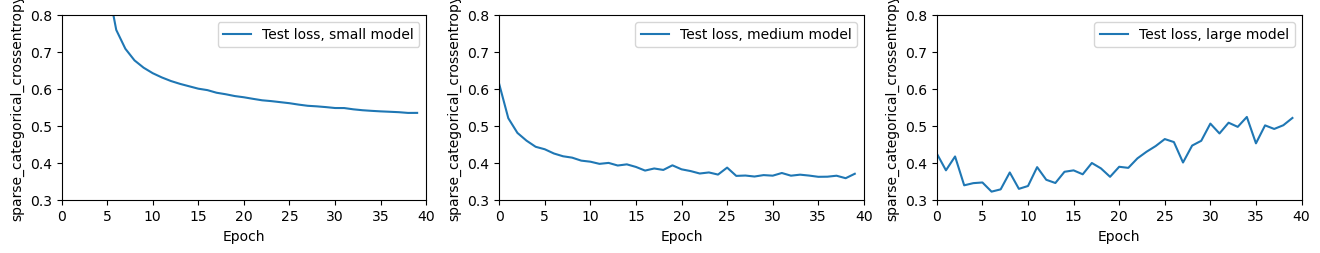

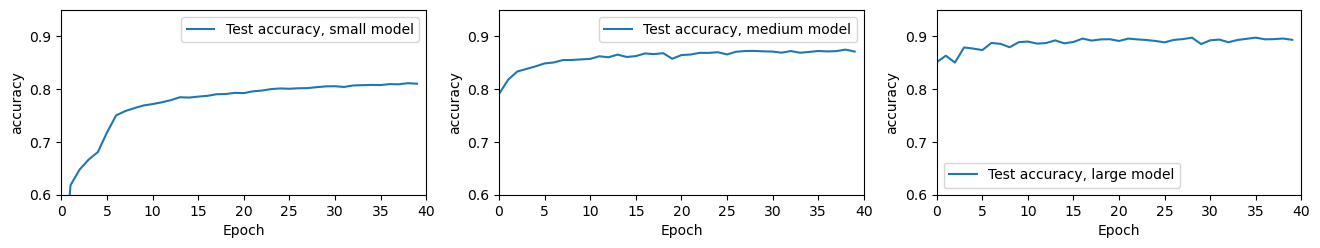

In [8]:
plot_histories(histories=[history_small, history_medium, history_large], 
               names=['small model', 'medium model', 'large model'], 
               measure='sparse_categorical_crossentropy',
               xlim_max=40,ylim_min=0.3,ylim_max=0.8)
plot_histories(histories=[history_small, history_medium, history_large], 
               names=['small model', 'medium model', 'large model'], 
               measure='accuracy', xlim_max=40,ylim_min=0.6,ylim_max=0.95)

In [9]:
model_small.evaluate(x_test, y_test)
model_medium.evaluate(x_test, y_test)
model_large.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.5212 - sparse_categorical_crossentropy: 0.5212 - accuracy: 0.8934


[0.5212408900260925, 0.5212408900260925, 0.8934000134468079]

## Early stopping

Think back to the prior figure. The large model ended up in poor conditions, but there was a moment during training where its performance was better than even the medium model.

So what if we could simply stop training at that point - or at least some point close by? Well, we can - enter early stopping.

Early stopping is very simple: introduce a rule for when to stop training, typically by monitoring the validation loss. You may then stop training the moment this value deteriorates, or perhaps when it has not improved for some time (such as three epochs).

Often, it is better to have some "*patience*" before stopping training. A model may be worse for a short time and then get "back on track". 

You may also simply restore the best model after training is finalized.

See https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more details.

In [10]:
model_small_es = build_model(1, 'relu', None, False, False)
model_medium_es = build_model(3, 'relu', None, False, False)
model_large_es = build_model(10, 'relu', None, False, False)

callback_small = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=3, 
                                                  restore_best_weights=True)
callback_medium = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=3, 
                                                   restore_best_weights=True)
callback_large = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=3, 
                                                  restore_best_weights=True)

In [11]:
history_small_es = model_small_es.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0, 
                                      callbacks=[callback_small])
history_medium_es = model_medium_es.fit(x_train, y_train, 
                                        validation_data=(x_test, y_test), 
                                        epochs=40, verbose=0,  
                                        callbacks=[callback_medium])
history_large_es = model_large_es.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0,  
                                      callbacks=[callback_large])

KeyboardInterrupt: 

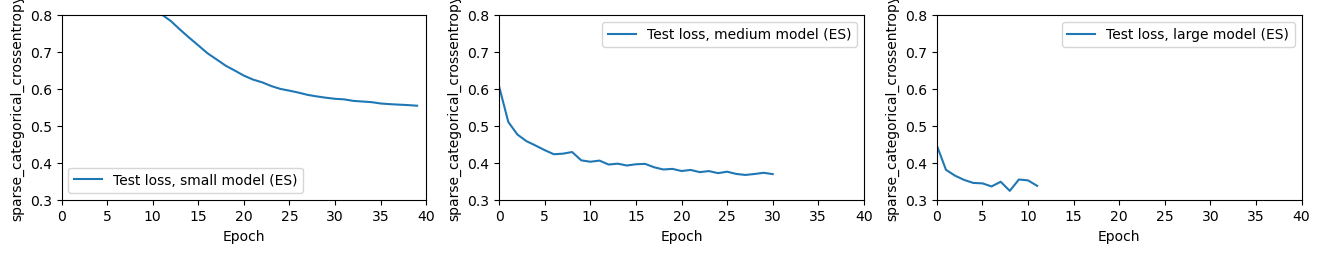

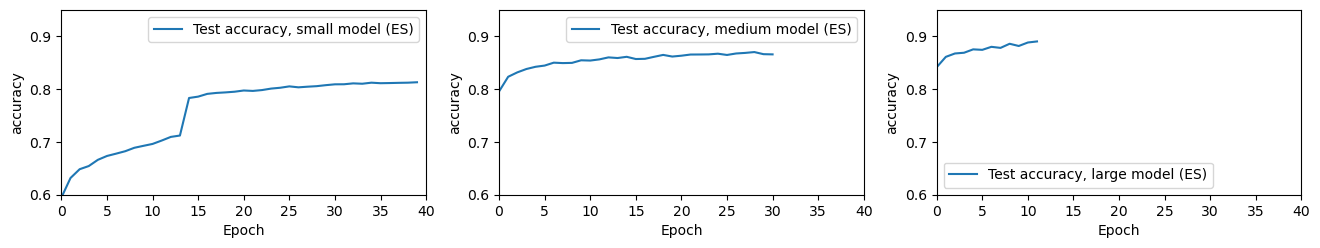

In [32]:
plot_histories(histories=[history_small_es, history_medium_es, 
                          history_large_es], 
               names=['small model (ES)', 'medium model (ES)', 
                      'large model (ES)'], 
               measure='sparse_categorical_crossentropy',              
               xlim_max=40,ylim_min=0.3,ylim_max=0.8)
plot_histories(histories=[history_small_es, history_medium_es,
                          history_large_es], 
               names=['small model (ES)', 'medium model (ES)', 
                      'large model (ES)'], 
               measure='accuracy', 
               xlim_max=40,ylim_min=0.6,ylim_max=0.95)

In [13]:
model_small_es.evaluate(x_test, y_test)
model_medium_es.evaluate(x_test, y_test)
model_large_es.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3240 - sparse_categorical_crossentropy: 0.3240 - accuracy: 0.8859


[0.3239881694316864, 0.3239881694316864, 0.8859000205993652]

## Weight regularization

Some of you may be familier with lasso and ridge regression. These ideas are directly applicable to neural networks.

The gist of these concepts is quite simple: *regularize* the values of the weights directly by including a *norm* of these in the loss function. Typically, one considers the L1 (lasso) or the L2 (ridge) norms, although others/combinations (such as the elastic net, which is L1 + L2) are occasionally useful.

In practice, the L2 norm is most often considered. For neural networks, it also sometimes goes by the name *weight decay*, as it "decays" the weights towards zero in each step, but do not be fooled - this is mathematically identical to the L2 norm.

L1 norm: $\sum_{w \in W} |w|$

L2 norm: $\sum_{w \in W} w^2$

The way it works is by inserting this into the loss function

## Weight regularization


For more details, see 

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

- https://www.tensorflow.org/api_docs/python/tf/keras/regularizers 

## Weight regularization

Suppose we write our neural network as a function $\hat{y} = F(X, W)$, where $\hat{y}$ is the prediction of the network, $X$ the input, and $W$ the parameters.

Suppose the loss function is then $l = L(y, \hat{y}) = L(y, F(X, W))$.

Adding for example an L2 norm then changes the loss function to $l = L(y, F(X, W)) + \lambda\sum_{w \in W} w^2$.

Where $\lambda$ is the strength of the regularization (which is a hyperparameter).

Note how $W$, i.e. the weights, enter into the equation at two points now - the first term will have a tendency to push the weights towards large values, whereas the second term works to push them toward zero. This is how it regularizes the network.

Applying L1 regularization, or any other type for that matter, is similar.

In [33]:
# 0.001 is the lambda term
model_small_wr = build_model(1, 'relu', tf.keras.regularizers.l2(0.001),
                             False, False) 
model_medium_wr = build_model(3, 'relu', tf.keras.regularizers.l2(0.001), 
                              False, False)
model_large_wr = build_model(10, 'relu', tf.keras.regularizers.l2(0.001), 
                             False, False)

In [15]:
history_small_wr = model_small_wr.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)
history_medium_wr = model_medium_wr.fit(x_train, y_train, 
                                        validation_data=(x_test, y_test), 
                                        epochs=40, verbose=0)
history_large_wr = model_large_wr.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)

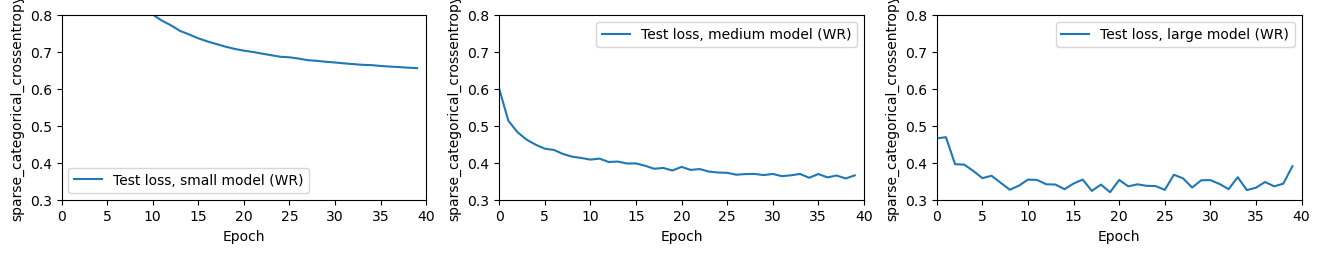

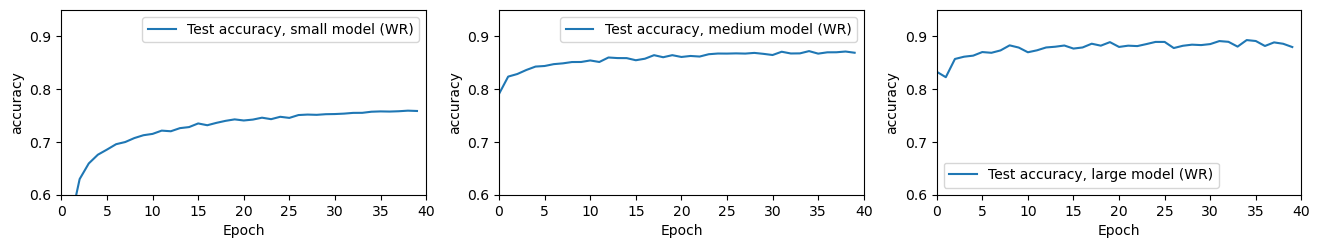

In [34]:
plot_histories(histories=[history_small_wr, history_medium_wr, 
                          history_large_wr], 
               names=['small model (WR)', 'medium model (WR)', 
                      'large model (WR)'], 
               measure='sparse_categorical_crossentropy',            
               xlim_max=40,ylim_min=0.3,ylim_max=0.8)
plot_histories(histories=[history_small_wr, history_medium_wr, 
                          history_large_wr], 
               names=['small model (WR)', 'medium model (WR)', 
                      'large model (WR)'], 
               measure='accuracy', 
               xlim_max=40,ylim_min=0.6,ylim_max=0.95)

In [17]:
model_small_wr.evaluate(x_test, y_test)
model_medium_wr.evaluate(x_test, y_test)
model_large_wr.evaluate(x_test, y_test)

  1/313 [..............................] - ETA: 4s - loss: 0.8745 - sparse_categorical_crossentropy: 0.8346 - accuracy: 0.6562

313/313 [==============================] - 1s 3ms/step - loss: 0.5370 - sparse_categorical_crossentropy: 0.3906 - accuracy: 0.8797


[0.5370317101478577, 0.39060264825820923, 0.8797000050544739]

## "Sidetrack" - weight initialization

Now that we're discussing weight regularization, another slightly related topic is weight initialization.

Before we start training a neural network, the weights must have some initial values. How do we choose these values?

There are broadly speaking two strategies for initializing the weights:
1. Choose the values randomly. Most often done - note that not all random values are created equal!

1. Use some pre-defined values you have a reason to believe are better than random. This applies mainly in *transfer learning* but also when some specific transformations are desired.

## "Sidetrack" - weight initialization

- Regarding the first point: The default weight initialization of TensorFlow layers is generally very good.

- Regarding the second point: We will discuss this (transfer learning) more throughout the semester, especially in relation to computer vision.

For more details, see: https://www.tensorflow.org/api_docs/python/tf/keras/initializers.


## Dropout

Recall ensembling? Recall how it helped reduce variance by combining models, which is very useful for strong learners? Neural networks are indeed very strong learners.

So why not use ensembling to avoid overfitting? Well, we can - and this is also done in practice - but is may be infeasible to any large extent. When we used random forests, we'd often use 1000 "base learners". But for a large network, which may take hours or even days to train? Have fun training 1000 examples!

But what if there was a way to approximate this ensemble of models? There is: **dropout**.

Dropout is a technique where some *nodes are randomly dropped during training*. As such, each forward pass through the network will be different - as different nodes will be dropped - resulting in a "sort of" ensemble of different models (each a subset, and thus thinner version, of the whole model).

## Dropout

<img src="./graphics/dropout.png" alt="Drawing" style="width: 800px;"/>

Source: "Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958."


## Dropout in practice

In practice, "dropping" a node simply means multiplying its outputs by zero (i.e. setting them all equal to zero).

However, multiplying some of the outputs by zero has the effect of shrinking the average outputs toward zero. To retain the expected value, we multiply the *remaining* outputs by $\frac{1}{1 - p}$, where $p$ is the probability of dropping a node.

When we are then done training, we no longer drop any nodes, which results in an approximate mean of the thinner models. Since we no longer drop any nodes, we scale all outputs with $p$, hence replace *output* with *expected output*.

This is a quite strong regularization technique. A weakness, however, is that training often takes longer (i.e. you need to train for more epochs), but this may be partly offset by using a higher learning rate and/or higher momentum.

## Dropout in practice

<img src="./graphics/dropout-train-test-difference.PNG" alt="Drawing" style="width:800px;"/>

Source: "Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958."


## Dropout in practice

For more details, see:

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

You may also want to read the original paper:

- https://jmlr.org/papers/v15/srivastava14a.html

## Why dropout works and how to use it

Dropout works by:
1. Introducing noise to the hidden nodes.
1. Limiting the potential of hidden nodes co-adapting.

This helps the network learn general patterns in the data rather than memorizing it.

In practice, we apply dropout layers after our hidden layers. Do not use it on the output layer, and think carefully about whether it makes sense to use on the input layer (in many settings it does not).

## Why dropout works and how to use it

The larger the model, the higher the values of dropout applied (typically). 

The dropout probability is a hyperparameter, and may as such be optimized similarly to how we otherwise find the best hyperparameters. 

However, it is very dependent on other parameters, such as model size and number of epochs, so these need to be considered jointly (i.e. higher dropout probability may warrant a larger model and more epochs).

Dropout is most commonly associated with fully connected layers (i.e. $\texttt{Dense}$ layers, the only type we've worked with directly so far), but they may be applied also to convolutional and recurrent layers. However, in these cases some adjustments are occasionally warranted.

In [18]:
model_small_do = build_model(1, 'relu', None, True, False)
model_medium_do = build_model(3, 'relu', None, True, False)
model_large_do = build_model(10, 'relu', None, True, False)

In [19]:
history_small_do = model_small_do.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)
history_medium_do = model_medium_do.fit(x_train, y_train, 
                                        validation_data=(x_test, y_test), 
                                        epochs=40, verbose=0)
history_large_do = model_large_do.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)

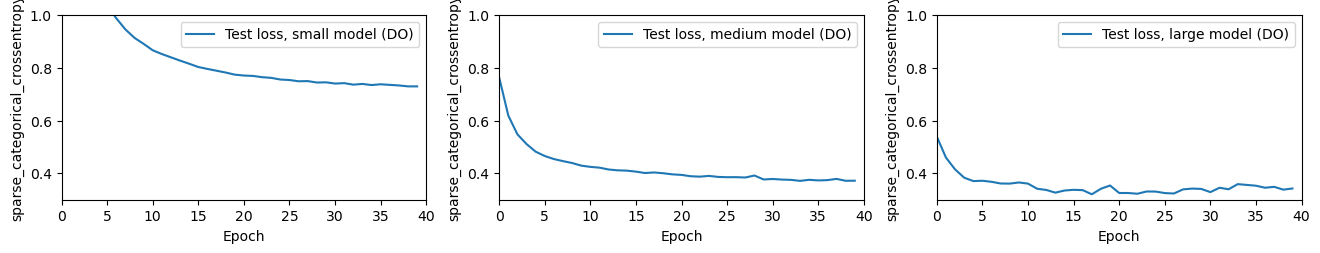

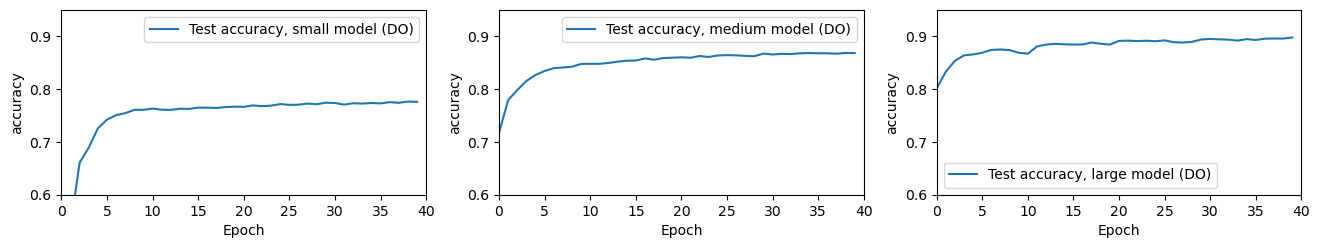

In [35]:
plot_histories(histories=[history_small_do, history_medium_do, 
                          history_large_do], 
               names=['small model (DO)', 'medium model (DO)', 
                      'large model (DO)'], 
               measure='sparse_categorical_crossentropy',            
               xlim_max=40,ylim_min=0.3,ylim_max=1)
plot_histories(histories=[history_small_do, history_medium_do, 
                          history_large_do], 
               names=['small model (DO)', 'medium model (DO)', 
                      'large model (DO)'], 
               measure='accuracy', 
               xlim_max=40,ylim_min=0.6,ylim_max=0.95)

In [21]:
model_small_do.evaluate(x_test, y_test)
model_medium_do.evaluate(x_test, y_test)
model_large_do.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3425 - sparse_categorical_crossentropy: 0.3425 - accuracy: 0.8979


[0.34252265095710754, 0.34252265095710754, 0.8978999853134155]

## Batch normalization

As training progresses, the distribution of the outputs of layers in a neural network changes. 

This is potentially problematic, as it:
1. Requires a lower learning rate, which slows down training.
1. Requires careful initialization.
1. May saturate non-linearities (making gradients, and thus updates to the parameters, small).

Ioffe, S., & Szegedy, C. refer to these problems as *internal covariate shift*, and adress the issues by introducing **batch normalization**. 

The idea is quite simple: after each layer, *normalize* the outputs.

## Motivating batch normalization

Recall how we often use $\texttt{sklearn}$'s $\texttt{StandardScaler}$ to scale our features. As discussed earlier, this is scaling each feature by substracting its mean and dividing by its standard deviation:

$z = \frac{x - \mu_x}{\sigma_x}$

This assures the transformed feature has mean 0 and standard deviation 1.

Now, if this is such a good idea, and since each layer in a neural network sort of creates "better features", why not also scale these in a similar fashion?

Well, why not? This is what batch normalization does, and it turns out it is **very** helpful.

## Batch normalization in practice

There is one small difficulty: we only pass *batches*, i.e. some of the data, through our network at once. As such, we cannot normalize by calculating the mean and standard deviation of the entire data! 

Further, these values change as training progresses (and the weights change). What to do?

You may start to see why the name **batch normalization** makes sense - we **normalize** these **batches**!

That is, we calculate the mean and standard deviation of the batch and normalize the batch using these values.

Where to place these layers? Some argue for before the nonlinearity, some argue for after.

## Batch normalization algorithm

<img src="./graphics/bn-algorithm.png" alt="Drawing" style="width: 600px;"/>

Source: "Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167."


## What is up with $\gamma$ and $\beta$?

If we only normalize each layer, i.e. substract its mean and divide by its standard deviation, we risk changing what the layer can represent. Perhaps we want a non-zero mean and/or a non-unity standard deviation!

To avoid this problem, Ioffe, S., & Szegedy, C. introduce $\gamma$ and $\beta$ to allow for the identity transformation, i.e. no transformation. 

But which values should these have? Well, let's just consider them parameters of the neural network and let it work its magic (i.e. we tune them similarly to the weights).

This "trick" - having the neural network learn what is best for a specific thing we want to try - is very general and a great strength of neural networks.

## How does batch normalization work after training?

During training, a crucial part of batch normalization is keeping track of the (running) means and standard deviations.

When training is done, we then use these values for the means and standard deviations instead of actually calculating them for each batch.

This is crucial to make sure inference is deterministic. If we did not do this, the predictions would change depending on the order we made then, and whether we predicted multiple times.

## Batch normalization regularizes the network

Perhaps surprisingly, batch normalization not only helps optimization speed but also regularizes the network.

Why? As we calculate the means and standard deviations on the batches, these are estimates and as such introduce some stochasticity, which helps regularize the model (as it introduces noise).

How? Now the value of an observation $i$ is directly impacted by the values of the rest of the observations in its batch. As such, even keeping the weights of the neural network fixed, the same observation may produce different outputs (varying as the other observations in its batch change).

## Final comments on batch normalization

Batch normalization is *almost* always a good idea. It speeds up training *and* regularizes the network - where a method such as dropout regularizes but slows down training. However, there are a few caveats:

1. Sometimes our batches are sampled from two (or more) different distributions, and we do not want to average across these (which batch normalization would when calculating means and standard deviations). This is rare, but in some cases very important.
1. Batch normalization uses the batches to calculate its statistics. Hence, a batch size of 1 does not allow the use of batch normalization.
1. The regularization of batch normalization decreases somewhat as the batch size gets very large. This is not a huge problem in practice.

## Final comments on batch normalization

For implementation details, see:

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization 

You may also want to read the original paper: 

- https://arxiv.org/abs/1502.03167.

In [22]:
model_small_bn = build_model(1, 'relu', None, False, True)
model_medium_bn = build_model(3, 'relu', None, False, True)
model_large_bn = build_model(10, 'relu', None, False, True)

In [23]:
history_small_bn = model_small_bn.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)
history_medium_bn = model_medium_bn.fit(x_train, y_train, 
                                        validation_data=(x_test, y_test), 
                                        epochs=40, verbose=0)
history_large_bn = model_large_bn.fit(x_train, y_train, 
                                      validation_data=(x_test, y_test), 
                                      epochs=40, verbose=0)

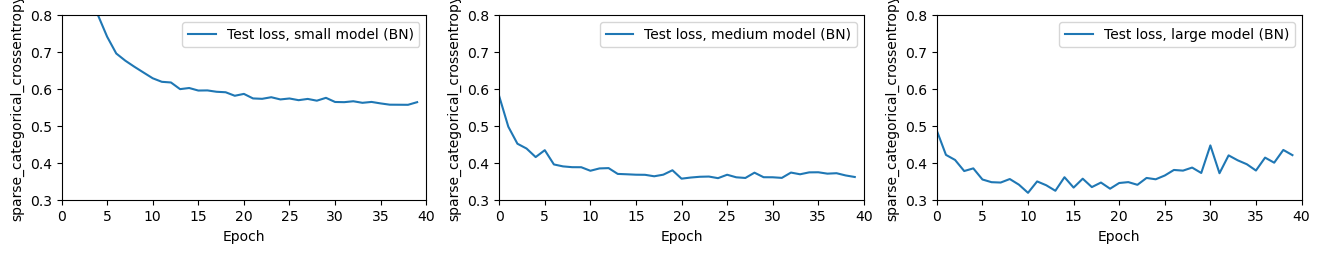

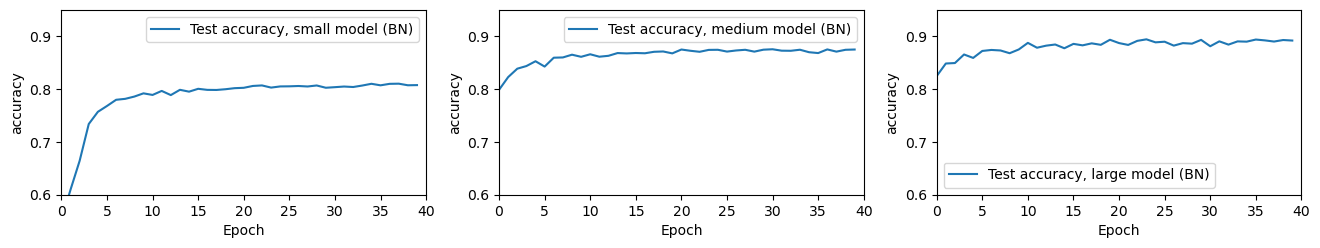

In [36]:
plot_histories(histories=[history_small_bn, history_medium_bn, 
                          history_large_bn], 
               names=['small model (BN)', 'medium model (BN)', 
                      'large model (BN)'], 
               measure='sparse_categorical_crossentropy',            
               xlim_max=40,ylim_min=0.3,ylim_max=0.8)
plot_histories(histories=[history_small_bn, history_medium_bn, 
                          history_large_bn], 
               names=['small model (BN)', 'medium model (BN)', 
                      'large model (BN)'], 
               measure='accuracy', 
               xlim_max=40,ylim_min=0.6,ylim_max=0.95)

In [25]:
model_small_bn.evaluate(x_test, y_test)
model_medium_bn.evaluate(x_test, y_test)
model_large_bn.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4207 - sparse_categorical_crossentropy: 0.4207 - accuracy: 0.8920


[0.420653760433197, 0.420653760433197, 0.8920000195503235]

## To illustrate training speed

To really illustrate how BN can speed up training, let us change from ReLU to sigmoid activation, which is a case where BN *really* speeds up training for deep models.

In [26]:
model_large_sigmoid = build_model(5, 'sigmoid', None, False, False)
model_large_sigmoid_bn = build_model(5, 'sigmoid', None, False, True)

In [27]:
history_large_sigmoid = model_large_sigmoid.fit(x_train, y_train, 
                                            validation_data=(x_test, y_test), 
                                            epochs=20, verbose=0)
history_large_sigmoid_bn = model_large_sigmoid_bn.fit(x_train, y_train, 
                                            validation_data=(x_test, y_test), 
                                            epochs=20, verbose=0)

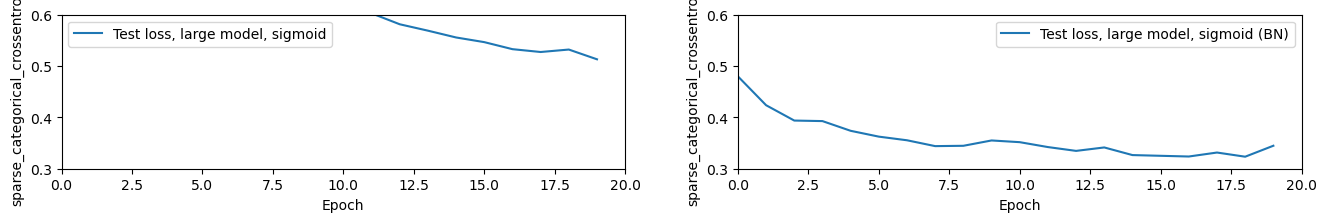

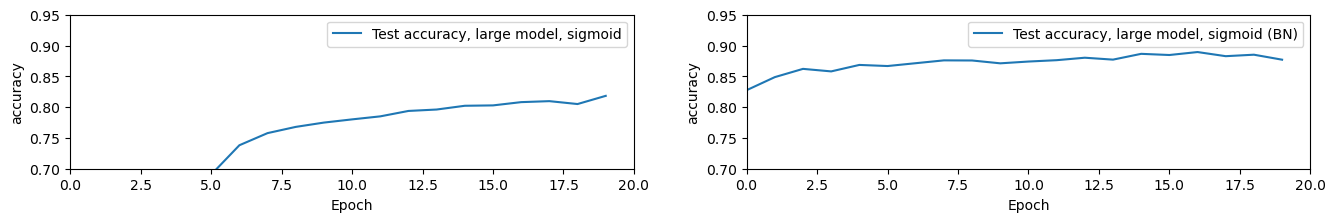

In [28]:
plot_histories(histories=[history_large_sigmoid, history_large_sigmoid_bn], 
               names=['large model, sigmoid', 'large model, sigmoid (BN)'], 
               measure='sparse_categorical_crossentropy', 
               xlim_max=20,ylim_min=0.3,ylim_max=0.6)
plot_histories(histories=[history_large_sigmoid, history_large_sigmoid_bn], 
               names=['large model, sigmoid', 'large model, sigmoid (BN)'], 
               measure='accuracy', 
               xlim_max=20,ylim_min=0.7,ylim_max=0.95)

In [29]:
model_large_sigmoid.evaluate(x_test, y_test)
model_large_sigmoid_bn.evaluate(x_test, y_test)

313/313 [==============================] - 0s 897us/step - loss: 0.3448 - sparse_categorical_crossentropy: 0.3448 - accuracy: 0.8770


[0.3447752296924591, 0.3447752296924591, 0.8769999742507935]

## Exercises

1. Use the fashion MNIST data. Build a baseline model and evaluate its performance. Go through (one at a time) early stopping, weight regularization, dropout, and batch normalization, and see how these change the performance of your model. Which method is - in isolation - best when applied to your model?
1. Now combine the methods, such as applying early stopping *and* dropout simultaneously. Optimally, try to work through all combinations (also of more than 2 methods).
1. Using a validation set and what you learned in (2), aim for the best model possible (preferably *without* using convolutional layers).

**Hint**: You may use the notebook I have uploaded under this lecture as a starting point ($\texttt{exercise-opt-reg.ipynb}$). It provides some of the code, and you then have to fill in the rest. You do not have to use it - it is there if you think it might be helpful!

## Data augmentation - a teaser

A key limitation to training successful neural networks is data limitations (i.e. not having enough data).

Even with the techniques presented in this lecture, we may still run into issues related to overfitting. Sometimes we can gather more data, but often it is infeasible or very time consuming/expensive.

What if we could simly create more data ourselves? It might sound crazy, but in some cases this is quite possible.

Think of an image of a dog. It represents one observation. Now, if we rotate it, flip it, shear it, blur it, or perform any number of such transformations, it is still an image of a dog. This line of thought - *image augmentation* is vital for computer vision. The same thing is less often, but still sometimes, possible outside of computer vision.

<img src="./graphics/augmentation.png" alt="Drawing" style="width: 600px;"/>

## Summary and looking ahead

In this lecture, we covered key regularization and optimization techniques to successfully build and train neural networks. These methods are some that we will return to throughout the semester. As such, this is a key lecture to continuously look back at when building neural networks.

Specifically, we discussed in some detail five key techniques - model size, early stopping, weight regularization, dropout, and batch normalization - including how and when they should be implemented, what problems they help solve, and in general their strengths and weaknesses.

Further, we briefly discussed data augmentation.

Great! What's next?

We'll move on to computer vision for the next two lecture, introducing a key technique - the use of convolutional rather than fully connected (i.e. $\texttt{Dense}$) layers - which is instrumental in achieving SOTA results in computer vision tasks. We will also cover several other topics, including pooling, data augmentation, and transfer learning. 